# Solvation and Absolute Free Energy Calculations of Alanine Dipeptide Conformations

In [102]:
from sys import stdout

import matplotlib.pyplot as plt
import mdtraj
import nglview
import numpy as np

#import openmm
from simtk.openmm import *
from simtk.openmm.app import *
import simtk.openmm.app  as omm_app
import simtk.openmm as omm

from simtk.unit import picosecond, femtoseconds, nanometer
from simtk.unit import *

def plot_ramachandran(traj, phi_atoms=None, psi_atoms=None):
    """
    Generate a basic Ramachandrom plot for a given trajectory.
    traj: An MDTraj trajectory object.
    phi_atoms: A list of atom names (in order) to identify the phi angle.
        The defaults in MDTraj do not work for termini in CHARMM
        topologies, which can be fixed with this argument.
    psi_atoms
        A list of atom names (in order) to identify the psi angle.
        The defaults in MDTraj do not work for termini in CHARMM
        topologies, which can be fixed with this argument.
    """
    from matplotlib.gridspec import GridSpec
    if phi_atoms is None:
        phis = mdtraj.compute_phi(traj)[1].ravel()
    else:
        phis = mdtraj.compute_dihedrals(
            traj, mdtraj.geometry.dihedral._atom_sequence(traj.topology, phi_atoms)[1])
    if psi_atoms is None:
        psis = mdtraj.compute_psi(traj)[1].ravel()
    else:
        psis = mdtraj.compute_dihedrals(
            traj, mdtraj.geometry.dihedral._atom_sequence(traj.topology, psi_atoms)[1])
    fig = plt.figure()
    gs = GridSpec(nrows=2, ncols=3)
    ax1 = fig.add_subplot(gs[:2, :2]) #Ramachandran plot
    ax1.plot(phis*180/np.pi, psis*180/np.pi, 'k+')
    ax1.set_aspect('equal', adjustable='box')
    ax1.axvline(0)
    ax1.axhline(0)
    ax1.set_xlim(-180, 180)
    ax1.set_ylim(-180, 180)
    ax1.set_xticks(np.linspace(-180, 180, 5))
    ax1.set_yticks(np.linspace(-180, 180, 5))
    ax1.set_xlabel("Phi [deg]")
    ax1.set_ylabel("Psi [deg]")
    ax2 = fig.add_subplot(gs[0, 2]) #Phi(t) plot
    ax2.plot(np.arange(len(phis)), phis*180/np.pi, 'k+')
    ax2.axhline(0)
    ax2.set_ylim(-180, 180)
    ax2.set_yticks(np.linspace(-180, 180, 5))
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Phi [deg]")
    ax3 = fig.add_subplot(gs[1, 2]) #Psi(t) plot
    ax3.plot(np.arange(len(phis)), psis*180/np.pi, 'k+')
    ax3.axhline(0)
    ax3.set_ylim(-180, 180)
    ax3.set_yticks(np.linspace(-180, 180, 5))
    ax3.set_xlabel("Step")
    ax3.set_ylabel("Psi [deg]")
    fig.tight_layout()

## 1.1. Absolute Free Energy Definition

Consider the definition of a parition function $Z$ for a molecular dynamics system and Helmholtz free energy $F(N, V, T)$.

$$Z = \int \int e^{-\beta H(\vec{r}, \vec{p})} \,d\vec{r} d\vec{p}$$

$$F = -\frac{\ln Z}{\beta} $$

However, typically free energy calculations usually only involve finding the free energy $Z_r$ due to configurations, since the equiparition theorem makes finding the $Z_p$ very easy.

$$H(\vec{r}, \vec{p}) = U(\vec{r}) + K(\vec{p})$$

$$Z = \int e^{-\beta V(\vec{r})} d\vec{r} \cdot \int e^{-\beta K(\vec{p})}d\vec{p}$$

$$Z = Z_r \cdot Z_p$$

Of course, the integral $Z_r = \int e^{-\beta V(\vec{r})} d\vec{r}$ is almost completely intractable, so Monte-Carlo or molecular dyanmics simulations can be used to estimate the integral. 

From now on, when we specify the parition function $Z$, we really mean $Z_r$ because $Z_p$ is trivial to compute, and solving for $Z_r$ is essentially solving for $Z$.

## 1.2 Absolute Free Energy of a Subsystem

Define a substate to be some allowed set of coordinates, $A \in \mathbb{R}^{3N}$. The partition function of that substate is then:

$$Z_{A} = \int_{\vec{r} \in A} e^{-\beta V(\vec{r})} d\vec{r}$$

The absolute free energy of that subsystem is then: 

$$F_{\mathbf{R} \rightarrow A} = -\frac{1}{\beta} \cdot \frac{\ln Z_A}{\ln Z_R}$$

It represents the relative probability of existing in $A$ versus the entire universe of allowed states $\mathbf{R}$.

## 1.2 AMBER Force Field 

The functional form of the AMBER force field is: 
$$ V(r) = \sum_{i \in \text{bonds}} k_{bi} (l_i - l_i^0)^2 + \sum k(\theta_i - \theta_i^0)^2 + \sum \sum \frac{1}{2} V_i^n[1+cos(n)]$$

1. $\sum_{i \in \text{bonds}} k_{bi} (l_i - l_i^0)^2$: this term describes the energy between covalently bonded atoms.

## 1.3 GBSA (Generalized Born, Surface Area)

Sus math.

## 1.4 Explicit Solvent

Explain the effect of Tip3 water solvent

## 1.5 Dialanine Comformations

<img src="dialanine_lolores.jpg">

Alanine dipeptide can have 4 or 6 metasable states depending on interpretation. If we must define two substates $A$ and $B$, we can define:

$A := \{ \forall \psi, \phi  \colon  \psi \in [-120 \degree, 30 \degree] = [-2.094 \text{ rad}, 0.5236 \text{  rad}], \phi \in [-180 \degree , 0 \degree] = [-3.14 \text{\ rad}, 0 \text{ \ rad}] \}$

$B := \{ \forall \psi, \phi  \colon  \psi \in [-180 \degree, -120 \degree] \cup [30 \degree, 180 \degree], \phi \in [-180 \degree , 10 \degree] \cup [120 \degree, 180 \degree] \}$

## 1.6 Biasing Potentials

$$

U_A(\theta)=
\begin{cases}
0 & \psi \in [-2.094 \text{ rad}, 0.5236 \text{  rad}], \phi \in [-3.14 \text{\ rad}, 0 \text{ \ rad}] \\
\infty &  \text{otherwise}
\end{cases}

$$

$$
U_B(\theta)=
\begin{cases}
0 & \psi \in [-180 \degree, -120 \degree] \cup [30 \degree, 180 \degree], \phi \in [-180 \degree , 10 \degree] \cup [120 \degree, 180 \degree] \\
\infty &  \text{otherwise}
\end{cases}

$$

## 1.7 Solvation Energy Thermodynamics

## 2.1 Implict Solvent

## Region A

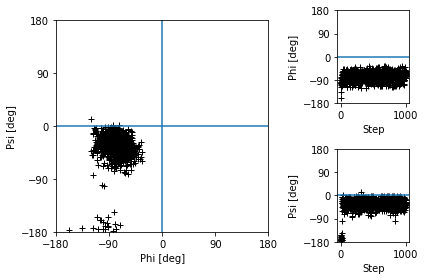

In [109]:
pdb = PDBFile('alanine-dipeptide.pdb')
forcefield = ForceField('amber99sbnmr.xml', 'amber99_obc.xml')
system = forcefield.createSystem(
    pdb.topology, nonbondedCutoff=3*nanometer, constraints=HBonds)
    
#ADD A PARTICLE IN A BOX BIASING, psi angles: 4, 6, 8, 14, phi angles: 6, 8, 14, 16
bias_torsion_phi = omm.CustomTorsionForce("15*( -erf(75*(theta+3.14)) + erf(75*(theta-0)) )")
bias_torsion_phi.addGlobalParameter("inf", 1000)
bias_torsion_phi.addGlobalParameter("tau", 2*math.pi)
bias_torsion_phi.addTorsion(6, 8, 14, 16) 
system.addForce(bias_torsion_phi)

bias_torsion_psi = omm.CustomTorsionForce("15*( -erf(75*(theta+2.094)) + erf(75*(theta-0.5236)) )")
bias_torsion_psi.addGlobalParameter("inf", 1e20)
bias_torsion_psi.addGlobalParameter("tau", 2*math.pi)
bias_torsion_psi.addTorsion(4, 6, 8, 14) 
system.addForce(bias_torsion_psi)

integrator = LangevinIntegrator(300*kelvin, 1/(0.1*picoseconds), 2*femtoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()

simulation.reporters = []
simulation.reporters.append(DCDReporter('traj2.dcd', 100))
simulation.step(100000)

traj2 = mdtraj.load('traj2.dcd', top='alanine-dipeptide.prmtop')
plot_ramachandran(traj2) #, phi_atoms=[6, 8, 14, 16], psi_atoms=[4, 6, 8, 14])

## Region B

In [ ]:
pdb = PDBFile('alanine-dipeptide.pdb')
forcefield = ForceField('amber99sbnmr.xml', 'amber99_obc.xml')
system = forcefield.createSystem(
    pdb.topology, nonbondedCutoff=3*nanometer, constraints=HBonds)

#Todos
#ADD A PARTICLE IN A BOX BIASING, psi angles: 4, 6, 8, 14, phi angles: 6, 8, 14, 16
#bias_torsion_phi = omm.CustomTorsionForce("15*( -erf(50*(theta+3)) + erf(50*(theta-0)) )")
bias_torsion_phi.addGlobalParameter("inf", 1000)
bias_torsion_phi.addGlobalParameter("tau", 2*math.pi)
bias_torsion_phi.addTorsion(6, 8, 14, 16) 
system.addForce(bias_torsion_phi)

#Todo
#bias_torsion_psi = omm.CustomTorsionForce("15*( -erf(50*(theta+2.1)) + erf(50*(theta-0.523)) )")
bias_torsion_psi.addGlobalParameter("inf", 1e20)
bias_torsion_psi.addGlobalParameter("tau", 2*math.pi)
bias_torsion_psi.addTorsion(4, 6, 8, 14) 
system.addForce(bias_torsion_psi)

integrator = LangevinIntegrator(300*kelvin, 1/picoseconds, 2*femtoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()

simulation.reporters = []
simulation.reporters.append(DCDReporter('traj3.dcd', 100))
simulation.step(100000)

traj2 = mdtraj.load('traj3.dcd', top='alanine-dipeptide.prmtop')
plot_ramachandran(traj2) #, phi_atoms=[6, 8, 14, 16], psi_atoms=[4, 6, 8, 14])

## Explicit Solvent Simulations

In [105]:
pdb = PDBFile('alanine-dipeptide.pdb')
modeller = Modeller(pdb.topology, pdb.positions)
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
modeller.addSolvent(forcefield, model='tip3p', padding=1*nanometer)
print(modeller.topology)
# Write a PDB file to provide a topology of the solvated
# system to MDTraj below.
with open('init3.pdb', 'w') as outfile:
    PDBFile.writeFile(modeller.topology, modeller.positions, outfile)

# The modeller builds a periodic box with the solute and solvent molecules.
# PME is the method to compute long-range electristatic interactions in
# periodic systems.
system = forcefield.createSystem(
    modeller.topology, nonbondedMethod=PME, constraints=HBonds)
temperature = 300 * kelvin
pressure = 1 * bar
integrator = LangevinIntegrator(temperature, 1/picosecond, 2*femtoseconds)
system.addForce(MonteCarloBarostat(pressure, temperature))
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy()
'''
simulation.reporters.append(DCDReporter('traj3.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars3.csv", 100, time=True, potentialEnergy=True, totalEnergy=True, temperature=True))
'''
simulation.step(100000)

<Topology; 2 chains, 661 residues, 1996 atoms, 1337 bonds>


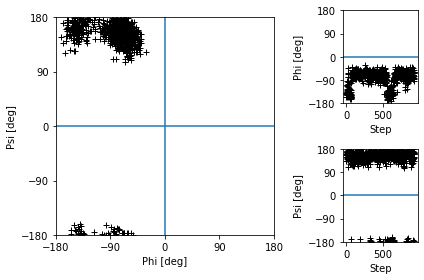

In [ ]:
traj3.restrict_atoms(traj3.topology.select("protein"))
plot_ramachandran(traj3[75:])

Probably need to make a restraining potential for the intervals $[-100, 85]$ and $[-100, 85]^c$.

## References and Required Readings

http://ambermd.org/tutorials/advanced/tutorial19/ for that picture of alanine-dipeptide conformations

https://en.wikipedia.org/wiki/Water_model#:~:text=In%20computational%20chemistry%2C%20a%20water,experimental%20results%2C%20and%20these%20combinations.